In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
print(jax.devices())

[cuda(id=0)]


In [3]:
data_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
data_test = pd.read_csv('/content/sample_data/mnist_test.csv')

In [4]:
train_set = jnp.array(data_train.values).T
n, m = train_set.shape
print(n, m)

key = jax.random.PRNGKey(45) # PRNG key for randomization

# Shuffle the dataset
train_set_shuffled = jax.random.permutation(key, train_set.T).T

Y_train = train_set_shuffled[0,:m].reshape(1,m).astype(jnp.float32)
X_train = train_set_shuffled[1:n,:m]
X_train = X_train / 255

print(Y_train.shape)
print(X_train.shape) #1 column is a single training example

test_set = jnp.array(data_test).T
p,q = test_set.shape
print(p,q)

# Y_test = test_set[0].reshape(1,q)
Y_test = test_set[0,:q].reshape(1,q).astype(jnp.float32)
X_test = test_set[1:p,:q] / 255



785 19999
(1, 19999)
(784, 19999)
785 9999


3.0


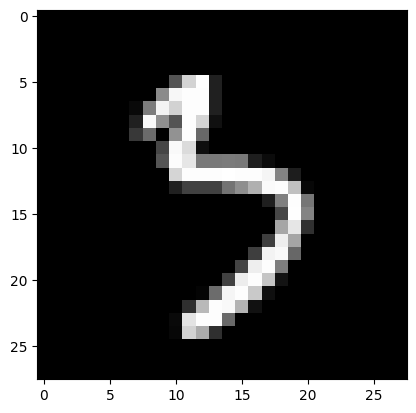

In [5]:
n = 100
plt.imshow(X_train[:,n].reshape(28,28),cmap='gray')
print(Y_train[0,n])
plt.show()


In [6]:
def one_hot(Y, n):
    return jax.nn.one_hot(Y, num_classes=n).astype(jnp.float32)

Y_train_oh = one_hot(Y_train, 10).squeeze() # had one extra dimension -> .squeeze()
Y_test_oh = one_hot(Y_test, 10).squeeze()

In [7]:


print(X_train.dtype)
print(Y_train.dtype)
print(Y_train_oh.shape)
print(Y_train_oh[100])

float32
float32
(19999, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [8]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    key = jax.random.PRNGKey(45)
    keys_l = jax.random.split(key, L-1)
    for l in range(1, L):
        parameters['W'+str(l)] = jax.random.normal(keys_l[l-1], (layer_dims[l],layer_dims[l-1]),dtype=jnp.float32)*0.01
        parameters['b'+str(l)] = jnp.zeros((layer_dims[l],1),dtype=jnp.float32)
    return parameters, L


In [9]:
# params['b1']

In [10]:
def linear(W, b, X):
    return jnp.dot(W, X) + b

def relu(Z):
    return jnp.maximum(0,Z)

def softmax(Z):
    exp_Z = jnp.exp(Z)
    return (exp_Z )/ jnp.sum(exp_Z, axis=0, keepdims=True)

def linear_relu(W, b, X):
    Z = linear(W, b, X)
    A = relu(Z)
    return A


In [11]:
def forward_prop(parameters, X, L):

  A = X
  for l in range(1, L-1):
    W = parameters['W'+str(l)]
    b = parameters['b'+str(l)]
    A = linear_relu(W, b, A)

  WL = parameters['W'+str(L-1)]
  bL = parameters['b'+str(L-1)]
  ZL = linear(WL, bL, A)
  AL = softmax(ZL)
  # print(AL.shape)
  return AL

@jit
def cost_function(parameters, X, Y):
  L = len(parameters) // 2  + 1
  AL = forward_prop(parameters, X, L)
  cost = -jnp.sum(Y*jnp.log(AL))/Y.shape[1]  #cross-entropy loss
  # cost = jnp.sum((AL-Y)**2)/Y.shape[1]  # MSE (didnt work)
  return cost

In [12]:
grad_fn = jax.grad(cost_function) # this automatically creates a computation graph(even for forward_prop)
# and calculate the gradients for the parameters in the dictionary


In [13]:
@jit
def update_params(parameters, grads, learning_rate):
  return {k: parameters[k] - learning_rate * grads[k] for k in parameters}

In [14]:
def accuracy(parameters, X, Y):
    L = len(parameters) // 2 + 1
    AL = forward_prop(parameters, X, L)
    # print(AL.shape)
    # print(Y.shape)
    predictions = jnp.argmax(AL, axis=0)
    true_labels = jnp.argmax(Y, axis=0)
    return jnp.sum(predictions == true_labels) / Y.shape[1]


In [15]:
#just creating a function for the model for easier testing
def model(X, Y, layer_dims, learning_rate , num_iterations):
    parameters, _ = initialize_parameters_deep(layer_dims)
    costs = []
    Y = Y.T
    # print(Y.shape)
    for i in range(num_iterations):
        grads = grad_fn(parameters, X, Y)
        parameters = update_params(parameters, grads, learning_rate)

        if i % 100 == 0:
            # print(grads, parameters)
            cost = cost_function(parameters, X, Y)
            acc = accuracy(parameters, X, Y)

            print(f"Iteration {i}: Cost = {cost}, Accuracy = {acc*100:.5f}%")

    return parameters, costs

In [16]:
# Training the model
layers_dims = [784,512,256,128,10]
parameters, costs = model(X_train, Y_train_oh, layers_dims, learning_rate=0.1, num_iterations=3000)

Iteration 0: Cost = 2.3025472164154053, Accuracy = 11.21556%
Iteration 100: Cost = 2.3008530139923096, Accuracy = 11.21556%
Iteration 200: Cost = 2.3005406856536865, Accuracy = 11.21556%
Iteration 300: Cost = 2.300368309020996, Accuracy = 11.21556%
Iteration 400: Cost = 2.3001339435577393, Accuracy = 11.21556%
Iteration 500: Cost = 2.29970645904541, Accuracy = 11.21556%
Iteration 600: Cost = 2.298701763153076, Accuracy = 11.21556%
Iteration 700: Cost = 2.2949728965759277, Accuracy = 11.21556%
Iteration 800: Cost = 2.2296338081359863, Accuracy = 20.87604%
Iteration 900: Cost = 1.6956428289413452, Accuracy = 33.34667%
Iteration 1000: Cost = 1.5011036396026611, Accuracy = 46.96735%
Iteration 1100: Cost = 0.9665881991386414, Accuracy = 60.30301%
Iteration 1200: Cost = 0.6085032224655151, Accuracy = 79.87900%
Iteration 1300: Cost = 0.4810492992401123, Accuracy = 85.32927%
Iteration 1400: Cost = 0.39859336614608765, Accuracy = 88.32941%
Iteration 1500: Cost = 0.33508187532424927, Accuracy = 

In [17]:
print(X_test.shape)
print(Y_test.shape)

(784, 9999)
(1, 9999)


In [18]:

AL = forward_prop(parameters, X_test, len(layers_dims))
print(AL.shape)
acc = accuracy(parameters, X_test, Y_test_oh.T)
print("Test Accuracy:",acc*100,'%')

(10, 9999)
Test Accuracy: 95.71957 %


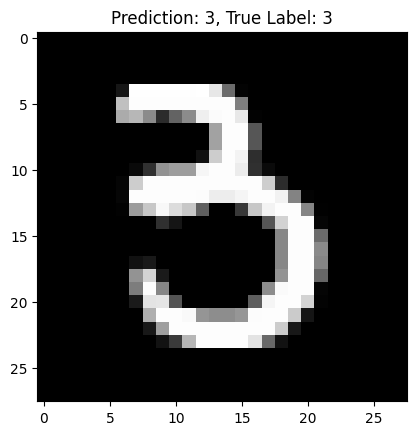

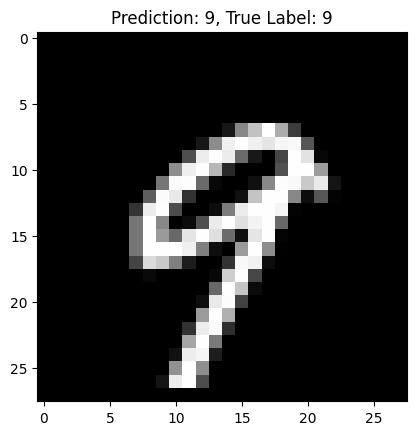

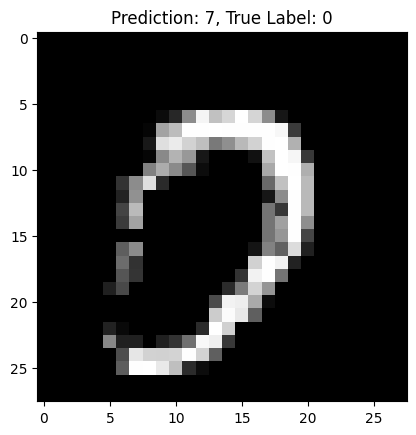

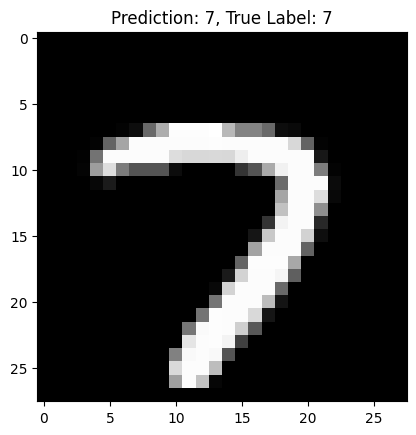

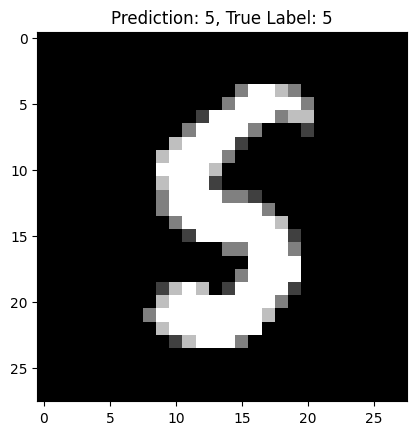

In [22]:
import numpy as np
import random

def predict_and_visualize(parameters, X_test, Y_test):


  i = random.randint(0, X_test.shape[1]-1)
  X = X_test[:,i].reshape(784,1)
  # Y_test is not one-hot encoded, so we need to select the correct label using the index i
  Y = Y_test[0,i]
  # convert Y to a one-hot encoded vector
  Y_one_hot = np.zeros((10,1))
  Y_one_hot[int(Y), 0] = 1
  L = len(parameters) // 2 + 1
  AL = forward_prop(parameters, X, L)
  prediction = jnp.argmax(AL)
  true_label = jnp.argmax(Y_one_hot)

  plt.imshow(X.reshape(28, 28), cmap='gray')
  plt.title(f"Prediction: {prediction}, True Label: {true_label}")
  plt.show()

predict_and_visualize(parameters, X_test, Y_test)
predict_and_visualize(parameters, X_test, Y_test)
predict_and_visualize(parameters, X_test, Y_test)
predict_and_visualize(parameters, X_test, Y_test)
predict_and_visualize(parameters, X_test, Y_test)
